In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBClassifier

runs = pd.read_pickle("../Data/main_1.df")

TARGET = "won"

FEATURES = ["horse_no", "horse_age", "horse_rating", "declared_weight", "actual_weight", 
            "win_odds", "draw", "race_size", "distance", "race_class", 
            'last_race_result','win_percent', 
            'avg_distance_time', 'normal_avg_distance_time',
            'going_type_record', 'actual_weight_scaled',
            'declared_weight_scaled', 'horse_race_count', "jockey_record",
            'trainer_record', 'horse_record', 'surface_record', 'place_odds',
            'weight_change', 'weight_change_over_time','weight_change_from_average', 'weight_change_increase',
            'venue_change','venue_record', 'days_since_last_race', 'new_horse',
            'best_odds', 'best_win_percent', 'best_distance_time', 'best_going_record', 
            'best_horse_record', 'best_jockey_record','best_trainer_record', 'highest_actual_weight', 
            'lowest_actual_weight', 'start_speed', 'rode_before',
#            'horse_type_Brown',
#            'horse_type_Colt', 'horse_type_Filly', 'horse_type_Gelding',
#            'horse_type_Grey', 'horse_type_Horse', 'horse_type_Mare',
#            'horse_type_Rig', 'horse_type_Roan', 'horse_country_ARG',
#            'horse_country_AUS', 'horse_country_BRZ', 'horse_country_CAN',
#            'horse_country_FR', 'horse_country_GB', 'horse_country_GER',
#            'horse_country_GR', 'horse_country_IRE', 'horse_country_ITY',
#            'horse_country_JPN', 'horse_country_NZ', 'horse_country_SAF',
#            'horse_country_SPA', 'horse_country_USA', 'horse_country_ZIM',
#           'going_type_fast', 'going_type_slow', 'going_type_wet'
] 

FEATURES = ['actual_weight','declared_weight','draw','win_odds','jockey_record','trainer_record',
'last_race_result','distance']

X = runs[FEATURES]
y = runs[TARGET]
testPct = 0.2
trainIndex = int(len(np.unique(runs["race_id"])) * (1-testPct))
max_race_id = np.unique(runs["race_id"])[trainIndex]
X_train = X.loc[runs["race_id"]<=max_race_id]
y_train = y.loc[runs["race_id"]<=max_race_id]
X_test = X.loc[runs["race_id"]>max_race_id]
y_test = y.loc[runs["race_id"]>max_race_id]

race_sizes_for_eval = [len(runs.loc[runs["race_id"]==race_id]["race_id"]) for race_id in np.unique(runs.loc[runs["race_id"]>max_race_id]["race_id"])]



In [27]:
def makeBets_1(model, X_train, y_train, X_test, y_test, test_race_sizes):
    # Fit and predict
    model.fit(X_train, y_train)
    all_preds = model.predict(X_test)
    
    money = [0]
    
    count = 0
    for s in test_race_sizes:
        lowI = count
        highI = count + s
        preds = all_preds[lowI:highI]
        act = y_test.iloc[lowI:highI]
        odds = X_test.iloc[lowI:highI, :]["win_odds"]
        
        newMoney = money[-1]

        if sum(preds)==1: # One win, bet on it
            win_horse_i = np.argmax(preds)
            if act.iloc[win_horse_i]==1:
                newMoney = money[-1] - 1 + odds.iloc[win_horse_i]
            else:
                newMoney = money[-1] - 1
        elif sum(preds)>1: # more than one win, find lowest odds one and bet on it
            win_horse_i = np.argmin(odds.iloc[np.where(preds==1)])
            if act.iloc[win_horse_i]==1:
                newMoney = money[-1] - 1 + odds.iloc[win_horse_i]
            else:
                newMoney = money[-1] - 1
            
        money.append(newMoney) 
        count += s
        
    return money

In [28]:
from sklearn.naive_bayes import GaussianNB
m = makeBets_1(GaussianNB(), X_train, y_train, X_test, y_test, race_sizes_for_eval)

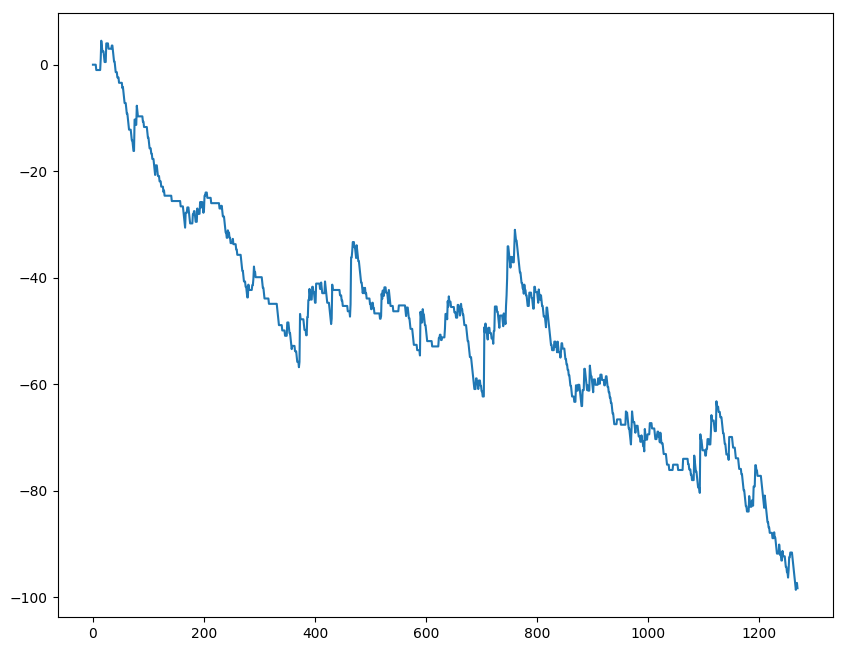

In [29]:
plt.figure(figsize=(10,8), dpi=100)
plt.plot(m)